In [1]:
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import numpy as np
from morning.pipeline.stream.cybos.stock.db.min_excel_tick import MinExcelTick
from morning.pipeline.converter.cybos.stock.day_tick import StockDayTickConverter
import pandas as pd
from datetime import date

In [2]:
from morning.pipeline.stream.cybos.stock.db.min_tick import MinTick
from morning.pipeline.chooser.cybos.db.kosdaq_all_chooser import KosdaqAllChooser
from morning.pipeline.chooser.cybos.db.kosdaq_bull_chooser import KosdaqBullChooser
from morning.back_data.fetch_stock_data import get_day_minute_period_data

from datetime import timedelta, datetime


In [50]:
def find_trend(x, indexes, prominences, is_upper):
    if not is_upper and indexes.shape[0] < 3:
        return False, False
    elif is_upper and indexes.shape[0] < 3:
        return False, True
    
    short_trend = x[indexes[-1]] - x[indexes[-2]] > 0
    for i, v1 in enumerate(reversed(indexes)):
        for v2 in reversed(indexes[:indexes.shape[0] - 1 - i]):
            found = True
            for c in indexes:
                if v1 == c or v2 == c: continue
                x1, x2, y1, y2, cx, cy = v1, v2, x[v1], x[v2], c, x[c]
                result = (y1 - y2) * cx + (x2 - x1) * cy + x1 * y2 - x2 * y1

                if (is_upper and result < 0) or (not is_upper and result > 0):
                    found = False
                    break
            
            if found:
                return short_trend, x[v1] - x[v2] > 0
    return short_trend, False

In [4]:
class Receiver:
    def __init__(self):
        self.data = []
    
    def received(self, datas):
        for d in datas:
            self.data.append(d)

def get_reversed(s):
    distance_from_mean = s.mean() - s
    return distance_from_mean + s.mean()

In [5]:
def calculate(df, is_rev, is_debug=False):
    x = None
    if not is_rev:
        x = df['avg']
    else:
        x = df['rev']

    peaks, _ = find_peaks(x, distance=10)
    prominences = peak_prominences(x, peaks)[0]

    peaks = np.extract(prominences > x.mean() * 0.003, peaks)
    prominences = np.extract(prominences > x.mean() * 0.003, prominences)
    #contour_heights = x[peaks] - prominences
    peaks = np.r_[np.array([0]), peaks]
    #peaks_end = np.r_[peaks[1:], np.array(x.count())]

    #contour_heights = np.r_[np.array([x[0]]), contour_heights]
    x = df['avg']
    utrend = find_trend(x, peaks, prominences, not is_rev)

    return peaks, prominences, utrend


In [78]:
from datetime import date
from morning.back_data.holidays import is_holidays
code_index = 0
from_date = date(2019, 11, 12)
from_datetime = datetime(from_date.year, from_date.month, from_date.day)

kbc = KosdaqBullChooser(from_datetime, from_datetime + timedelta(days=1))
codes = kbc.codes[-1].values()
codes = list(codes)[2:]


In [82]:
#code_index += 1

sdtc = StockDayTickConverter()
gdmpd = get_day_minute_period_data(codes[code_index], from_date, from_date)
print(codes[code_index])
#met = MinExcelTick('sample_data/20191129_A028300.xlsx')
met = MinTick(from_date)
met.set_target('cybos:' + codes[code_index])
met.set_output(sdtc)
rcv = Receiver()
sdtc.set_output(rcv)
open_price = 0
stage = 0
buy_prices = [0, 0]
buy_points = []
sell_points = []
risks = []
buy_hold = None
while met.received(None) > 0:
    data = rcv.data

    if open_price == 0:
        open_price = data[-1]['start_price']

    if len(data) < 10: continue

    df = pd.DataFrame(data)

    if buy_hold is not None and df['date'].iloc[-1] - buy_hold < timedelta(minutes=10):
        continue

    df['avg'] = df['close_price'].rolling(10).mean()
    not_non = df['avg'].notna().idxmax()
    if not_non > 0:
        #print(df['avg'].iloc[not_non])
        df['avg'] = df['avg'].fillna(open_price)
    price = np.array(df['avg'])
    reverse_price = np.array(get_reversed(price))
    df['rev'] = reverse_price
    peaks, prominences, utrend = calculate(df, False)
    peaks_b, prominences_b, utrend_b = calculate(df, True)

    bottom_trend = utrend_b[0] and utrend_b[1]
    roof_trend = utrend[0] and utrend[1]
    cum_sum = (data[-1]['cum_buy_volume'] + data[-1]['cum_sell_volume']) * 0.1
    volume_trend = data[-1]['cum_buy_volume'] > data[-1]['cum_sell_volume'] + cum_sum
    """
    if df['date'].iloc[-1] > datetime(2019, 12, 6, 13, 6):
        print('utrend', utrend_b[0], utrend_b[1])
        calculate(df, True, True)
        break
    """
    if stage == 0:
        bottom_trend = utrend_b[0] and utrend_b[1]
        roof_trend = utrend[0] and utrend[1]
        volume_trend = data[-1]['cum_buy_volume'] > data[-1]['cum_sell_volume']
        price_exceed = (data[-1]['close_price'] - open_price) / open_price * 100. > 15.
        if bottom_trend and not roof_trend and volume_trend and not price_exceed:
            stage = 1
            buy_prices[0] = df['avg'].iloc[peaks[-1]]
            buy_prices[1] = df['avg'].iloc[peaks[-2]]
            print('Go S1', df['date'].iloc[-1], buy_prices)
            
    elif stage == 1:
        #print(df['date'].iloc[-1], utrend_b[0], utrend_b[1])
        if not volume_trend or not bottom_trend:
            if buy_hold is not None:
                print('SELL', df['date'].iloc[-1], df['close_price'].iloc[-1])
                sell_points.append(df['date'].iloc[-1])
                buy_hold = None
            stage = 0
        else:
            start_price = df['close_price'].iloc[-5:].min()
            close_price = df['close_price'].iloc[-5:].max()
            risk = float("{0:.2f}".format((close_price - start_price) / start_price * 100.))
            
            if buy_hold is None and (df['avg'].iloc[-1] > buy_prices[0] or df['avg'].iloc[-1] > buy_prices[1]):
                buy_points.append(df['date'].iloc[-1])
                buy_hold = df['date'].iloc[-1]
                print('BUY1', df['date'].iloc[-1], df['close_price'].iloc[-1])
                risks.append(risk)
            """
            if buy_points[1] == 0 and df['avg'].iloc[-1] > buy_prices[1]:
                buy_points2.append(df['date'].iloc[-1])
                buy_points[1] = df['date'].iloc[-1]
                print('BUY2', df['date'].iloc[-1], df['close_price'].iloc[-1])
            """ 

        


A052420
Length 380
Go S1 2019-11-12 10:58:00 [2829.5, 2914.0]
Go S1 2019-11-12 11:00:00 [2829.5, 2914.0]
Go S1 2019-11-12 11:02:00 [2829.5, 2914.0]
Go S1 2019-11-12 11:04:00 [2829.5, 2914.0]
Go S1 2019-11-12 11:06:00 [2829.5, 2914.0]
Go S1 2019-11-12 11:08:00 [2829.5, 2914.0]
Go S1 2019-11-12 11:10:00 [2829.5, 2914.0]
Go S1 2019-11-12 11:12:00 [2829.5, 2914.0]
Go S1 2019-11-12 11:14:00 [2829.5, 2914.0]
Go S1 2019-11-12 11:16:00 [2829.5, 2914.0]
Go S1 2019-11-12 11:39:00 [2829.0, 2829.5]
Go S1 2019-11-12 11:41:00 [2829.0, 2829.5]
Go S1 2019-11-12 11:43:00 [2829.0, 2829.5]
Go S1 2019-11-12 11:45:00 [2829.0, 2829.5]
Go S1 2019-11-12 11:47:00 [2829.0, 2829.5]
Go S1 2019-11-12 11:49:00 [2829.0, 2829.5]
Go S1 2019-11-12 11:51:00 [2829.0, 2829.5]
Go S1 2019-11-12 11:53:00 [2829.0, 2829.5]
Go S1 2019-11-12 11:55:00 [2829.0, 2829.5]
Go S1 2019-11-12 11:57:00 [2829.0, 2829.5]
Go S1 2019-11-12 11:59:00 [2829.0, 2829.5]
Go S1 2019-11-12 12:01:00 [2829.0, 2829.5]
Go S1 2019-11-12 12:03:00 [2829.0, 

[Timestamp('2019-11-12 12:12:00')]


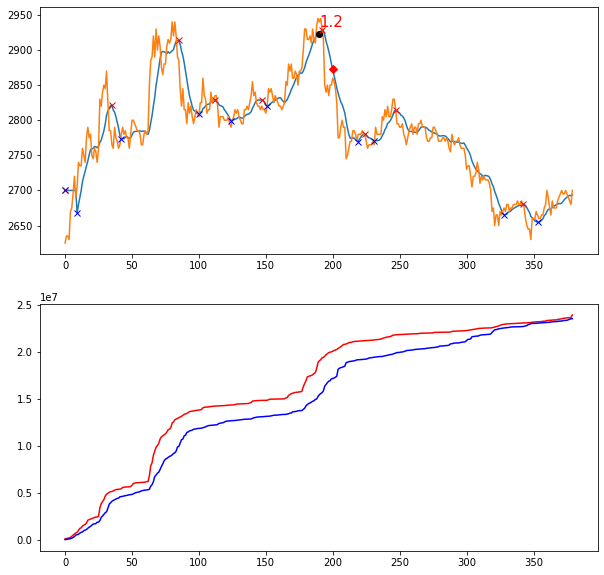

In [81]:

data = rcv.data
df = pd.DataFrame(data)

df['buy1'] = False
df['sell1'] = False
open_price = 0
for b1 in buy_points:
    df.loc[df['date'] == b1, 'buy1'] = True

for s1 in sell_points:
    df.loc[df['date'] == s1, 'sell1'] = True
print(buy_points)
if open_price == 0:
    open_price = data[-1]['start_price']
    
df['avg'] = df['close_price'].rolling(10).mean()
not_non = df['avg'].notna().idxmax()
if not_non > 0:
    df['avg'] = df['avg'].fillna(open_price)
price = np.array(df['avg'])
reverse_price = np.array(get_reversed(price))
df['rev'] = reverse_price
x = df['avg']

peaks, prominences, utrend = calculate(df, False)
peaks_b, prominences_b, utrend_b = calculate(df, True)
plt.rcParams['figure.figsize'] = [10, 10]
fig, axs = plt.subplots(2)
axs[0].plot(x)
axs[0].plot(df['close_price'])

buy1 = df[df['buy1']]
axs[0].plot(df[df['buy1'] == True].index.values, df.loc[df['buy1'] == True, 'avg'], 'o', color='black', markersize=6)

axs[0].plot(df[df['sell1'] == True].index.values, df.loc[df['sell1'] == True, 'avg'], 'D', color='red', markersize=6)
axs[0].plot(peaks, x[peaks], 'x', color='red')
axs[0].plot(peaks_b, x[peaks_b], 'x', color='blue')
#axs[0].plot(utrend[:2], utrend[2:], color='black')
#axs[0].vlines(x=peaks, ymin=contour_heights, ymax=x[peaks], linewidth=1)
risk_index = df[df['buy1'] == True].index.values
risk_v = df.loc[df['buy1'] == True, 'avg']        
for i, p in enumerate(risks):
    axs[0].annotate(str(p), (risk_index[i], risk_v.iloc[i] * 1.003), fontsize=15, color='red')
        

#axs[0].hlines(x[peaks], peaks, peaks + peaks_end - peaks, linewidth=1, color='red')
axs[1].plot(df['cum_buy_volume'], color='red')
axs[1].plot(df['cum_sell_volume'], color='blue')


#plt.rcParams['figure.figsize'] = [10, 5]
#plt.plot(x)
#axs[0].plot(peaks, x[peaks_bottom], 'x')
#axs[0].plot(utrend[:2], utrend[2:], color='blue')
#axs[0].hlines(x[peaks_bottom], peaks_bottom, peaks_bottom + peaks_end_bottom - peaks_bottom, linewidth=1, color='blue')


#### find_peaks and peak prominence testing